## Stark Broadening Asymmetries From SPY

[The SPY survey](https://ui.adsabs.harvard.edu/abs/2020A%26A...638A.131N/abstract) has a ton of high-res WD spectra. I'm gonna see how much Stark broadening affects their absorption lines.

In [52]:
import glob
import os
import numpy as np

from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt
plt.style.use('../../proj/core-composition/notebooks/stefan.mplstyle')

In [ ]:
from astropy.io import ascii, fits
from astropy.table import Table
import hashlib
import urllib.request
import re

def read_spectrum(dirpath, download_files = False):
    dirpath = os.path.abspath(dirpath)
    objects = Table.read('http://cdsarc.u-strasbg.fr/viz-bin/nph-Cat/fits.gz?J/A+A/638/A131/objects.dat')
    objects['FileName'] = [re.sub(r'dat', 'dat.gz', s).replace(' ', '') for s in objects['FileName']]
    objects['Name'] = [s.replace(' ', '') for s in objects['Name']]
    objects['id'] = [hashlib.sha256(f"{file}".encode()).hexdigest()[:16] for file in objects['FileName']]
    info_table, spec_table = {}, {}

    for id, file in zip(objects['id'], objects['FileName']):
        path = os.path.join(dirpath, file)
        if not os.path.isfile(path):
            if download_files:
                print(f"Downloading {path}")
                urllib.request.urlretrieve(f"http://cdsarc.u-strasbg.fr/ftp/J/A+A/638/A131/sp/{file}", filename=path)
            else:
                continue
            
        table = ascii.read(path)
        print(id, path)
        snr = 20
        wl = table['Table'].data
        fl = table[':'].data
        ivar =  snr**2 / (table[':'].data + 1e-6)**2
        spec_table[id] = (wl, fl, ivar)

    return spec_table, objects

spec_table, objects = read_spectrum('./data/raw')

5cc35d694a33b175 /mnt/d/arsen/research/misc/stark_broadening/data/raw/EC12489m2750_a_2000_07_13T01_26_13_all.dat.gz
2f09e3816b4b142e /mnt/d/arsen/research/misc/stark_broadening/data/raw/EC12489m2750_b_2000_07_15T23_51_15_all.dat.gz
724401fd44c5dfe7 /mnt/d/arsen/research/misc/stark_broadening/data/raw/EC13123m2523_a_2000_04_22T03_01_23_all.dat.gz
1ffb3aec93908517 /mnt/d/arsen/research/misc/stark_broadening/data/raw/EC13123m2523_b_2000_04_25T05_27_39_all.dat.gz
cf959dbaae4b6af0 /mnt/d/arsen/research/misc/stark_broadening/data/raw/HE0031m5525_a_2002_07_27T06_08_16_all.dat.gz
ced816a05a11189d /mnt/d/arsen/research/misc/stark_broadening/data/raw/HE0031m5525_b_2001_12_17T00_51_42_all.dat.gz
c83b655955c66004 /mnt/d/arsen/research/misc/stark_broadening/data/raw/HE0032m2744_a_2002_09_15T03_00_04_all.dat.gz
49947ad5bea0eb87 /mnt/d/arsen/research/misc/stark_broadening/data/raw/HE0032m2744_b_2002_09_18T03_06_51_all.dat.gz
2c9e04a4aaccb5e9 /mnt/d/arsen/research/misc/stark_broadening/data/raw/HE0043

In [34]:
import corv
from tqdm import tqdm

def test_windows(wl, fl, ivar, n = 10):
    window = dict(a = 15, b = 15,)
    edges = dict(a = 0, b = 0)
    rv_data = []
    windows = []

    steps = np.linspace(0, 85, n)
    for step in tqdm(steps):
        temp_window = window.copy()
        temp_window['a'] += step
        temp_window['b'] += step
        
        corvmodel = corv.models.WarwickDAModel(model_name='1d_da_nlte', names = ['a', 'b'], resolution = 0.0637, windows=temp_window, edges=edges)
        rv, e_rv, redchi, param_res = corv.fit.fit_corv(wl, fl, ivar, corvmodel.model)

        rv_data.append([rv, e_rv, param_res])
        windows.append([temp_window['a'], temp_window['b']])

    return np.array(rv_data), np.array(windows)

def process_results(parameters, windows, plot=True, **kwargs):
    rvs, e_rvs, params = parameters[:,0], parameters[:,1], parameters[:,1]
    windows = windows[:,0]
    diff = rvs - rvs[0]
    significance = lambda rv, e_rv : (rv - rvs[0]) / np.sqrt(e_rv**2 + e_rvs[0]**2)
    sigs = [significance(r, e) for r, e in zip(rvs, e_rvs)]

    if plot:
        fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(10,10), **kwargs)
        ax1.errorbar(windows, diff, yerr = e_rvs, fmt='o', c = 'k', markersize=8, capsize=10)
        ax1.axhline(y=0, c='k', ls='--')
        ax1.set_ylabel('$RV - RV_0$ [$km/s]$')

        ax2.scatter(windows, sigs, s = 40, c = 'k')
        ax2.axhline(y=0, c='k', ls='--')
        
        ymin, ymax = ax2.get_ylim()
        if (ymax < 2):
            ax2.set_ylim(ymin,2)
        ymin, ymax = ax2.get_ylim()
        if (ymin > -2):
            ax2.set_ylim(-2, ymax)

        xmin, xmax = ax2.get_xlim()
        ax2.fill_between([xmin,xmax], -1, 1, color='green', alpha=0.5, zorder=0)
        ax2.set_xlim(xmin, xmax)
        ax2.set_ylabel('$\\chi$ Agreement')
        ax2.set_xlabel(r'Fit Window Size [$\AA$]')

    res_dict = {
        'windows' : windows,
        'rvs' : rvs,
        'e_rvs' : e_rvs,
        'differentials' : diff,
        'significance' : sigs
    }
    return res_dict

<>:50: SyntaxWarning: invalid escape sequence '\c'
<>:50: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_49543/1163302642.py:50: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel('$\chi^2$ Agreement')


In [46]:
spec_table

{'5cc35d694a33b175': (array([3290.06, 3290.1 , 3290.14, ..., 6641.89, 6641.94, 6641.99]),
  array([0.    , 0.    , 0.    , ..., 0.209 , 0.2052, 0.2108]),
  array([4.00000000e+14, 4.00000000e+14, 4.00000000e+14, ...,
         9.15721188e+03, 9.49950653e+03, 9.00149527e+03])),
 '2f09e3816b4b142e': (array([3290.06, 3290.1 , 3290.14, ..., 6641.89, 6641.94, 6641.99]),
  array([0.    , 0.    , 0.    , ..., 0.2272, 0.234 , 0.2539]),
  array([4.00000000e+14, 4.00000000e+14, 4.00000000e+14, ...,
         7.74889033e+03, 7.30507307e+03, 6.20484831e+03])),
 '724401fd44c5dfe7': (array([3290.05, 3290.09, 3290.13, ..., 6641.88, 6641.93, 6641.98]),
  array([0.    , 0.    , 0.    , ..., 0.4068, 0.3914, 0.3848]),
  array([4.00000000e+14, 4.00000000e+14, 4.00000000e+14, ...,
         2.41710751e+03, 2.61105566e+03, 2.70139199e+03])),
 '1ffb3aec93908517': (array([3290.05, 3290.09, 3290.13, ..., 6641.88, 6641.93, 6641.98]),
  array([0.    , 0.    , 0.    , ..., 0.3857, 0.3916, 0.3909]),
  array([4.0000000

In [51]:
import json

def write_dict_to_json(dictionary, filename):
    def convert_ndarray(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        
    with open(filename, 'w') as json_file:
        json.dump(dictionary, json_file, indent=4, default=convert_ndarray)

def analyze_spectra(spec_dict, from_cache=True):
    with open('./data/processed/rv_windows.json') as json_file:
        cache = json.load(json_file)
    results = {}
    for key in spec_dict.keys():
        if from_cache and (key not in list(cache.keys())):
            print(key)
            wl, fl, ivar = spec_dict[key]
            parameters, windows = test_windows(wl, fl, ivar)
            results[key] = process_results(parameters, windows, plot=False)
            write_dict_to_json(results, './data/processed/rv_windows.json')
        elif not from_cache:
            print(key)
            wl, fl, ivar = spec_dict[key]
            parameters, windows = test_windows(wl, fl, ivar)
            results[key] = process_results(parameters, windows, plot=False)
            write_dict_to_json(results, './data/processed/rv_windows.json')
    return results

results = analyze_spectra(spec_table)

2f09e3816b4b142e


  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [01:11<00:07,  7.99s/it]


KeyboardInterrupt: 

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_49543/2507066450.py:12: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel('$\chi^2$ Agreement')
/tmp/ipykernel_49543/2507066450.py:29: SyntaxWarning: invalid escape sequence '\c'
  ax.errorbar(wl, mean_sig, yerr = std_sig, label = f'Mean $\chi^2$ (n = {len(result_dict.keys())})', c = 'k', fmt = 'o', markersize=8, capsize=10)
/tmp/ipykernel_49543/2507066450.py:30: SyntaxWarning: invalid escape sequence '\c'
  ax.scatter(wl, median_sig, label = f'Median $\chi^2$ (n = {len(result_dict.keys())})', c = 'blue', s = 60, zorder=10)
/tmp/ipykernel_49543/2507066450.py:3

ValueError: 'yerr' must not contain negative values

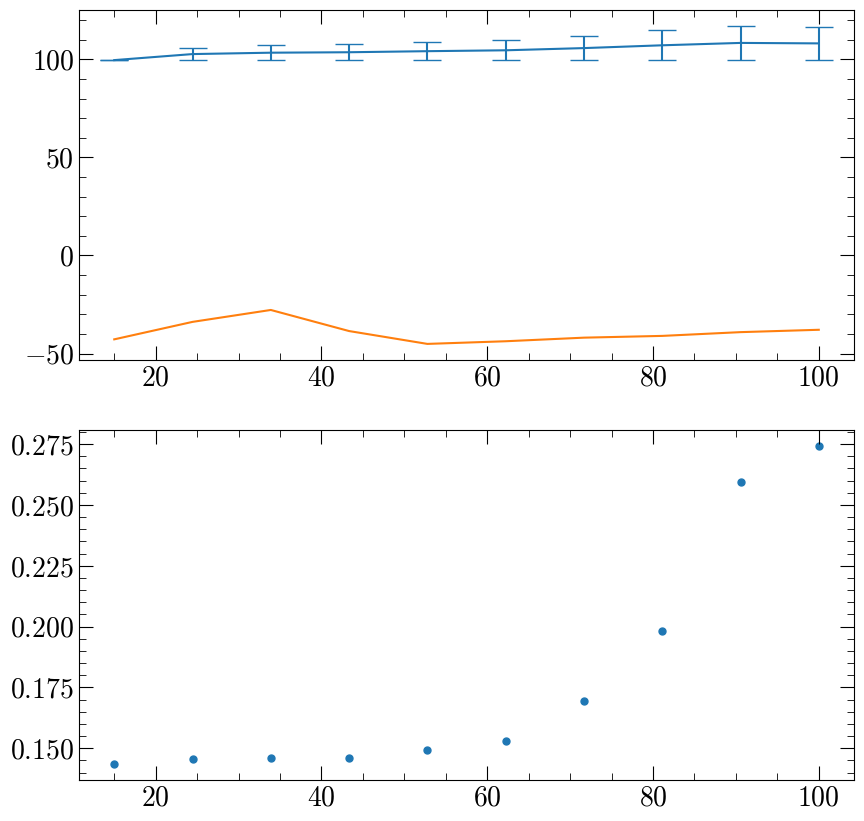

In [27]:
def plot_ensemble(result_dict):
    fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(10,10))

    for key in result_dict.keys():
        ax1.errorbar(result_dict[key][:,0], result_dict[key][:,1], yerr = result_dict[key][:,2], markersize=8, capsize=10)
        ax2.scatter(result_dict[key][:,0], result_dict[key][:,3])
    
    ax1.axhline(y = 0, c = 'k', ls = '--')
    ax1.set_ylabel('$RV - RV_0$ [$km/s]$')

    ax2.axhline(y = 0, c = 'k', ls = '--')
    ax2.set_ylabel('$\\chi$ Agreement')
    ax2.set_xlabel(r'Fit Window Size [$\AA$]')

    fig, ax = plt.subplots(nrows = 1, figsize=(10,6))

    sigs, wls = [], []
    for key in result_dict.keys():
        wls.append(result_dict[key][:,0])
        sigs.append(result_dict[key][:,3])
    sigs = np.array(sigs)

    wl = wls[0]
    mean_sig = np.average(sigs, axis=0)
    median_sig = np.median(sigs, axis=0)
    std_sig = np.std(sigs, axis=0)

    scatter = {'s' : 40}
    ax.errorbar(wl, mean_sig, yerr = std_sig, label = f'Mean $\chi^2$ (n = {len(result_dict.keys())})', c = 'k', fmt = 'o', markersize=8, capsize=10)
    ax.scatter(wl, median_sig, label = f'Median $\chi^2$ (n = {len(result_dict.keys())})', c = 'blue', s = 60, zorder=10)

    xmin, xmax = ax.get_xlim()
    ax.fill_between([xmin,xmax], -1, 1, color='green', alpha=0.5, zorder=0)
    ax.set_xlim(xmin, xmax)
    ax.axhline(y = 0, c = 'k', ls = '--')
    
    ax.set_xlabel(r'Fit Window Size [$\AA$]')
    ax.set_ylabel('$\chi^2$ Agreement')
    ax.legend(framealpha=0)

plot_ensemble(results)